In [1]:
import sklearn
import sklearn.datasets
from matplotlib import pylab as plt
import numpy as np
from itertools import cycle,islice

In [301]:
import copy

In [2]:
import torch
import torchvision
import torchdiffeq

In [315]:
import models
import importlib
importlib.reload(models)
from models import *

In [231]:
colors = np.array(list(islice(cycle(
    ['#377eb8', '#ff7f00', '#4daf4a',
     '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00']),
    int(max([1]) + 1))))

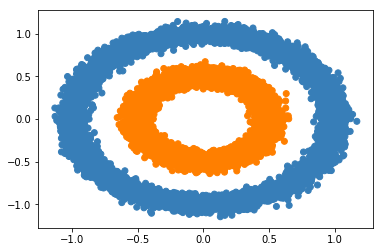

In [232]:
X,Y = sklearn.datasets.make_circles(n_samples=15000, factor=.5,
                                      noise=.05)
plt.scatter(X[:,0],X[:,1],color=colors[Y])

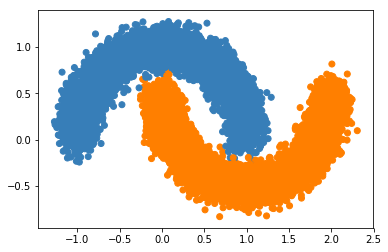

In [136]:
X,Y = sklearn.datasets.make_moons(n_samples=15000,noise=0.1)

plt.scatter(X[:,0],X[:,1],color=colors[Y])

In [152]:
def plot_pred(model):
    pred = torch.sigmoid(model( torch.tensor(X[:1000,:],dtype=torch.float32) ))
    P = pred.detach().numpy()
    P = np.array(np.around(P),dtype=np.int)
    plt.scatter(X[:1000,0],X[:1000,1],color=colors[list(P.flatten())])

In [345]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [116]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X,dtype=torch.float),torch.tensor(Y,dtype=torch.float).reshape(-1,1))
loader = torch.utils.data.DataLoader(dataset,batch_size=64)

In [128]:
model = ShallowNet(2,1,hidden=4,Act=torch.nn.LeakyReLU)

In [123]:
model = DeepNet((2,4,4,4,1),Act=torch.nn.LeakyReLU)

In [334]:
def refine(net):
    try:
        return net.refine()
    except AttributeError:
        if type(net) is torch.nn.Sequential:
            return torch.nn.Sequential(*[
                refine(m) for m in net
            ])
        else:
            raise RuntimeError("Hit a network that cannot be refined.")
            # Error is for debugging. This makes sense too:
            # return net

In [424]:
class ODEModel(torch.nn.Module):
    def __init__(self,i_dim,o_dim,ode_width=4,
                 inside_width=4,Act=torch.nn.ReLU,
                method='euler'):
        super(ODEModel,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(i_dim,ode_width),
            ODEBlock(
                ShallowODE(ode_width,hidden=inside_width,
                           Act=Act),
                method='euler'),
            #ODEBlock(ShallowODE(ode_width,hidden=12,Act=Act)),
            torch.nn.Linear(ode_width,o_dim),
        )
    def forward(self,x):
        # Missing sigmoid
        y = self.net(x)
        return y
    def refine(self):
        new = copy.deepcopy(self)
        new.net[1] = refine(self.net[1])
        return new

In [425]:
model = ODEModel(2,1,ode_width=4,inside_width=4,
                 Act=torch.nn.LeakyReLU,method='euler')

In [426]:
epochs = 5
N_print= 10000

In [427]:
def train_for_epochs(model, N_epochs, losses = None):
    if losses is None:
        losses = []
    plot_pred(model)
    plt.show()
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
    step_count = 0
    for e in range(N_epochs):
        for imgs,labels in iter(loader):
            #imgs = imgs.reshape(-1,784)
            #print(imgs.shape)
            optimizer.zero_grad()
            #loss = -torch.log()
            out = model(imgs)
            #print(out,labels)
            L = criterion(out,labels)
            L.backward()
            optimizer.step()
            losses.append(L.detach().numpy())
            if step_count % N_print == N_print-1:
                print(L.detach())
                plot_pred(model)
                plt.show()
            step_count += 1
    return losses

Starting with  57


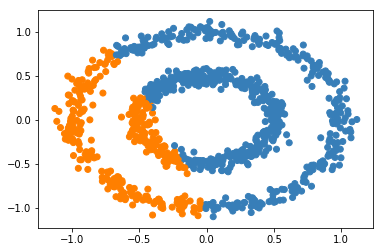

Adapting to  97


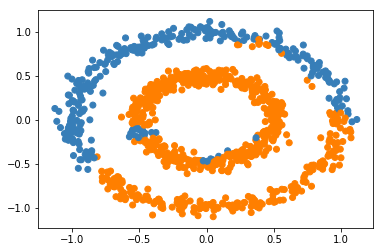

In [ ]:
losses = []
refine_steps = []
models = [model]
for i in range(5):
    if i > 0:
        models.append(models[-1].refine())
        print("Adapting to ",count_parameters(models[-1]))
    else:
        print("Starting with ",count_parameters(models[-1]))
    losses = train_for_epochs(models[-1],epochs,losses)
    refine_steps.append(len(losses))

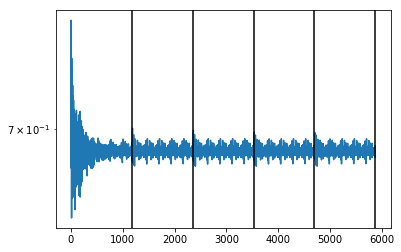

In [422]:
plt.semilogy(losses)
for r in refine_steps:
    plt.axvline(r,color='k')

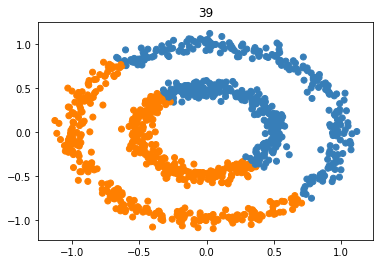

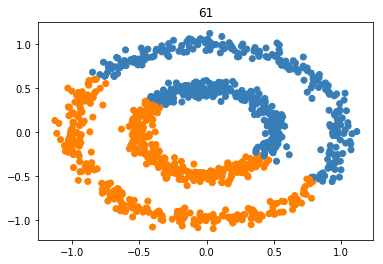

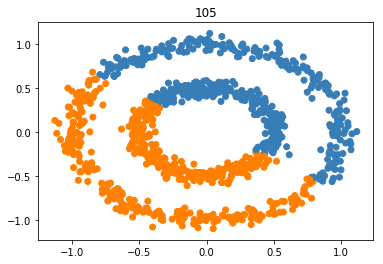

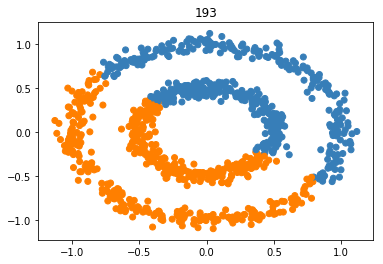

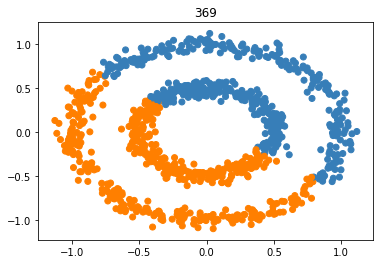

In [423]:
for m in models:
    plt.title(count_parameters(m))
    plot_pred(m)
    plt.show()